In [26]:
import os
from tqdm import tqdm_notebook as tqdm
###
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
from scipy.sparse import *
import nltk
import random
###
import networkx as nx
from node2vec import Node2Vec
from gensim.models import word2vec, KeyedVectors 
###
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
###
import xgboost as xgb
###
import torch
import torch.nn as nn

random.seed(10)
device = torch.device('cpu')

## Data processing

In [5]:
nltk.download('punkt') # for tokenization
nltk.download('stopwords')
stpwds = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.PorterStemmer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chene\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chene\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def compute_network_characteristics(graph):
    prop = {}
    prop['N'] =  graph.number_of_nodes() # number of nodes
    prop['M'] = graph.number_of_edges() # number of edges
    degrees = [degree for node, degree in graph.degree()] # degree list
    prop['min_degree'] =  np.min(degrees) # minimum degree
    prop['max_degree'] =  np.max(degrees) # maximum degree
    prop['mean_degree'] = np.mean(degrees) # mean of node degrees
    prop['median_degree'] = np.median(degrees) # median of node degrees
    prop['density'] =  nx.density(graph) # density of the graph
    return prop

### Turning the training data into a graph

In [7]:
def get_training_graph(csv_file, column_names=['source', 'target', 'connected']):

    # Pandas dataframe
    df = pd.read_csv(csv_file, sep=' ', names=column_names)
    edges = df.loc[df['connected'] == 1]

    # Number of edges
    print(f'There are {len(edges)} edges and {len(df) - len(edges)} non edges')

    # networkx graph
    Graphtype = nx.DiGraph()
    G = nx.from_pandas_edgelist(edges, create_using=Graphtype)
    
    return G

In [8]:
training_graph = get_training_graph('training_set.txt')
compute_network_characteristics(graph=training_graph)

There are 335130 edges and 280382 non edges


{'N': 27684,
 'M': 335130,
 'min_degree': 1,
 'max_degree': 2346,
 'mean_degree': 24.211096662332032,
 'median_degree': 14.0,
 'density': 0.0004372917794735403}

In [63]:
def smaller_graph(training_set, ratio = 0.5):
    size_reduced = int((len(training_set)*ratio))
    index_mask =  random.sample(range(len(training_set)), k= size_reduced)
    training_set_reduced = [training_set[i] for i in index_mask]

    df = pd.DataFrame(training_set_reduced, columns=['source', 'target', 'connected'])
    edges = df.loc[df['connected'] == '1']

    # Number of edges
    print(f'There are {len(edges)} edges and {len(df) - len(edges)} non edges')

    # networkx graph !!!!!!! The graph is directed
    Graphtype = nx.DiGraph()
    G = nx.from_pandas_edgelist(edges, create_using=Graphtype)

    # Take the largest weakly conected component
    nodes = max(nx.strongly_connected_components(G), key=len) 
    G0 = G.subgraph(nodes)

    weak_conn = nx.is_weakly_connected(G0)
    print('The graph is weakly connected: ',weak_conn)
    return G,G0

In [10]:
with open("training_set.txt", "r") as f:
    reader = csv.reader(f)
    training_set  = list(reader)

training_set = [element[0].split(" ") for element in training_set]
ratio = 0.5
G,G0 = smaller_graph(training_set, ratio = ratio)

print('Info graph')
compute_network_characteristics(G0)

There are 167561 edges and 140195 non edges
The graph is weakly connected:  True
Info graph


{'N': 3168,
 'M': 22513,
 'min_degree': 2,
 'max_degree': 470,
 'mean_degree': 14.212752525252526,
 'median_degree': 11.0,
 'density': 0.0022438826216060193}

### Generate Samples

In [11]:
def real_labels(graph, samples):
    labels = []
    for edge in tqdm(samples):
        if edge in graph.edges():
            labels.append(1)
        else:
            labels.append(0)
    return labels

In [12]:
def generate_samples(complete_graph, graph, train_set_ratio):
    """
    Graph pre-processing step required to perform supervised link prediction
    Create training and test sets
    """
        
    # --- Step 0: The graph must be connected ---
    if nx.is_weakly_connected(graph) is not True:
        raise ValueError("The graph contains more than one connected component!")
       
    
    # --- Step 1: Generate positive edge samples for testing set ---
    residual_g = graph.copy()
    test_pos_samples = []
      
    # Store the shuffled list of current edges of the graph
    edges = list(residual_g.edges())
    np.random.shuffle(edges)
    
    # Define number of positive test samples desired
    test_set_size = int((1.0 - train_set_ratio) * graph.number_of_edges())
    train_set_size = graph.number_of_edges() - test_set_size
    num_of_pos_test_samples = 0
    
    # Remove random edges from the graph, leaving it connected
    # Fill in the blanks
    for edge in tqdm(edges,total = test_set_size):
        
        # Remove the edge
        residual_g.remove_edge(edge[0], edge[1])
        
        # Add the removed edge to the positive sample list if the network is still connected
        if nx.is_weakly_connected(residual_g):
            num_of_pos_test_samples += 1
            test_pos_samples.append(edge)
        # Otherwise, re-add the edge to the network
        else: 
            residual_g.add_edge(edge[0], edge[1])
        
        # If we have collected enough number of edges for testing set, we can terminate the loop
        if num_of_pos_test_samples == test_set_size:
            break
    
    # Check if we have the desired number of positive samples for testing set 
    if num_of_pos_test_samples != test_set_size:
        raise ValueError("Enough positive edge samples could not be found!")

        
    # --- Step 2: Generate positive edge samples for training set ---
    # The remaining edges are simply considered for positive samples of the training set
    train_pos_samples = list(residual_g.edges())
        
        
    # --- Step 3: Generate the negative samples for testing and training sets ---
    # Fill in the blanks
    non_edges = list(nx.non_edges(graph))
    random.seed(10)
    np.random.shuffle(non_edges)
    
    train_neg_samples = non_edges[:train_set_size] 
    test_neg_samples = non_edges[train_set_size:train_set_size + test_set_size]

    
    # --- Step 4: Combine sample lists and create corresponding labels ---
    # For training set
    train_samples = train_pos_samples + train_neg_samples
    train_labels = [1 for _ in train_pos_samples] + [0 for _ in train_neg_samples]
    # For testing set
    test_samples = test_pos_samples + test_neg_samples
    test_labels = real_labels(complete_graph, test_samples) # !!!! G et pas G0
    
    return residual_g, train_samples, train_labels, test_samples, test_labels

In [13]:
residual_g, train_samples, train_labels, val_samples, val_labels = generate_samples(G, G0, train_set_ratio=0.8)

### Random Walk (feature extraction directed graph)

In [60]:
def feature_extractor_walk(graph, samples, node2embedding, dimension, feature_func = None):
    """
    Creates a feature vector for each edge of the graph contained in samples 
    """    
    # --- Construct feature vectors for edges ---
    if feature_func is None:
        feature_func = lambda x,y: abs(x-y)
        
    count_key_error = 0

    # Fill in the blanks
    feature_vector = []
    for edge in samples:
        source_node = edge[0]
        target_node = edge[1]
        
        try:
            source_embedding = node2embedding[source_node]

        except KeyError:
            source_embedding = np.ones(dimension)
            count_key_error +=1
            
        try:
            target_embedding = node2embedding[target_node]
        except KeyError:
            target_embedding = np.ones(dimension)
            count_key_error +=1
            
        feature_vector.append(feature_func(source_embedding, target_embedding))
        
    print(f'Number of elements not found: {count_key_error}/{2*len(samples)}')
        
    return np.array(feature_vector)

In [64]:
num_of_walks = 50
walk_length = 30
embedding_size = 8
window_size = 5

node2vec = Node2Vec(residual_g, dimensions=embedding_size, walk_length=walk_length,
                    num_walks=num_of_walks, workers=4)
# Embed nodes
model = node2vec.fit(window=window_size, min_count=1, batch_words=4)

In [18]:
embedding_size = 8

train_features = feature_extractor_walk(G0, train_samples, model.wv, embedding_size)
val_features = feature_extractor_walk(G0, val_samples, model.wv, embedding_size)

In [19]:
# --- Build the model and train it ---
# Fill in the blanks
clf = LogisticRegression()
clf.fit(train_features, train_labels)

train_proba= clf.predict_proba(train_features)[:, 1]
val_proba = clf.predict_proba(val_features)[:, 1]
val_pred = clf.predict(val_features)

print(f'Accuracy: {accuracy_score(val_labels, val_pred)}')
print(f'F1 score: {f1_score(val_labels, val_pred)}')

# --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
# Fill in the blanks
fpr, tpr, _ = roc_curve(val_labels, val_proba)
roc_auc = auc(fpr, tpr)
print(roc_auc)

Accuracy: 0.7928698356286095
F1 score: 0.7802521503475904
0.8746134547832138


In [20]:
def feature_extractor_undirected(graph, samples, deg_centrality):
    """
    Creates a feature vector for each edge of the graph contained in samples 
    """
    feature_vector = []
    number_nodes_out = 0

    for edge in tqdm(samples):
        source_node, target_node = edge[0], edge[1]

        # Degree Centrality
        if (source_node not in list(deg_centrality.keys())) or (target_node not in list(deg_centrality.keys())):
            feature_vector.append(np.array([0, 0, 0, 0, 0, 0]))
            number_nodes_out += 1

        else:

            source_degree_centrality = deg_centrality[source_node]
            target_degree_centrality = deg_centrality[target_node]
#             source_katz_cent = katz_cent[source_node]
#             target_katz_cent = katz_cent[target_node]
            
            # # Betweeness centrality measure 
            #diff_bt = betweeness_centrality[target_node] - betweeness_centrality[source_node]

            # Preferential Attachement 
            pref_attach = list(nx.preferential_attachment(graph, [(source_node, target_node)]))[0][2]

            # AdamicAdar
            aai = list(nx.adamic_adar_index(graph, [(source_node, target_node)]))[0][2]

            # Jaccard
            jacard_coeff = list(nx.jaccard_coefficient(graph, [(source_node, target_node)]))[0][2]
            # Ressource allocation index
            res_all = list(nx.resource_allocation_index(graph, [(source_node, target_node)]))[0][2]
            
            # Create edge feature vector with all metric computed above
            feature_vector.append(np.array([source_degree_centrality, target_degree_centrality, pref_attach, aai, jacard_coeff, res_all]) ) 
    print(number_nodes_out)
        
    return np.array(feature_vector)

In [21]:
G_undirected = G0.to_undirected()
print("degree centrality")
deg_centrality = nx.degree_centrality(G_undirected)
print("done!")
train_features_undirected = feature_extractor_undirected(G_undirected, train_samples, deg_centrality)
val_features_undirected = feature_extractor_undirected(G_undirected, val_samples, deg_centrality)

degree centrality
done!


0


0


In [22]:
###Merge features
train_features = np.concatenate([train_features,train_features_undirected],axis=1)
val_features = np.concatenate([val_features,val_features_undirected],axis=1)

### Node info

In [23]:
column_names = ['id', 'year', 'title', 'authors', 'journal', 'abstract']
info = pd.read_csv('node_information.csv', sep=',', names=column_names)
info.head()

,id,year,title,authors,journal,abstract
0,1001,2000,compactification geometry and duality,Paul S. Aspinwall,NaN,these are notes based on lectures given at tas...
1,1002,2000,domain walls and massive gauged supergravity p...,"M. Cvetic, H. Lu, C.N. Pope",Class.Quant.Grav.,we point out that massive gauged supergravity ...
2,1003,2000,comment on metric fluctuations in brane worlds,"Y.S. Myung, Gungwon Kang",NaN,recently ivanov and volovich hep-th 9912242 cl...
3,1004,2000,moving mirrors and thermodynamic paradoxes,Adam D. Helfer,Phys.Rev.,quantum fields responding to moving mirrors ha...
4,1005,2000,bundles of chiral blocks and boundary conditio...,"J. Fuchs, C. Schweigert",NaN,proceedings of lie iii clausthal july 1999 var...


In [24]:
with open("node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info  = list(reader)


IDs = [element[0] for element in node_info]
abstracts = [element[5] for element in node_info]

In [88]:
#embedded_title = []
#embedded_abstract = []

#for element in tqdm(node_info):
  #embedded_title.append(model_similarity.encode(element[2], convert_to_tensor=True))
  #embedded_abstract.append(model_similarity.encode(element[5], convert_to_tensor=True))

In [27]:
embedded_title = torch.load('embedding_title.pth',map_location=device)
embedded_abstract = torch.load('embedding_abstract.pth',map_location=device)

In [28]:
title_stemmed = []

for element in tqdm(node_info):
    title = element[2].lower().split(" ")
    # remove stopwords
    title = [token for token in title if token not in stpwds]
    title = [stemmer.stem(token) for token in title]
    title_stemmed.append(title)

In [29]:
def isselfcite(source_auth, target_auth): 
    selfcite = 0
    for sauth in source_auth: 
        if sauth in target_auth: 
            selfcite = 1
            break 
    return selfcite

def issamejournal(source_journal, target_journal): 
    
    if source_journal == target_journal: 
        same_journal = 1
    else:
        same_journal = 0
    return same_journal

In [39]:
cos = nn.CosineSimilarity(dim=0, eps=1e-6)
def processing_info(sample):
    sim_title = []

    # temporal distance between the papers
    temp_diff = []

    # number of common authors
    comm_auth = []

    #is self citation
    self_cite = []

    #is published in same journal 
    same_journal = []

    #cosine  similarity 
    sim_abstract = []

    for i in tqdm(range(len(sample))):
        source = sample[i][0]
        target = sample[i][1]

        index_source = IDs.index(source)
        index_target = IDs.index(target)

        source_info = node_info[index_source]
        target_info = node_info[index_target]

        # Title
        source_title = title_stemmed[index_source]
        target_title = title_stemmed[index_target]
        sim_title.append(len(set(source_title).intersection(set(target_title))))

        
        #source_title_embedding = embedded_title[index_source]
        #target_title_embedding = embedded_title[index_target]
        #sim_title.append(util.pytorch_cos_sim(source_title_embedding, target_title_embedding).item())

        #Date
        temp_diff.append(int(source_info[1]) - int(target_info[1]))

        #Authors
        source_auth = source_info[3].split(",")
        target_auth = target_info[3].split(",")
        comm_auth.append(len(set(source_auth).intersection(set(target_auth))))
        self_cite.append(isselfcite(source_auth,target_auth))

        #Journal
        source_journal = source_info[4].lower()
        target_journal = target_info[4].lower()
        same_journal.append(issamejournal(source_journal, target_journal))

        source_abstract = source_info[5].lower()
        target_abstract = target_info[5].lower()

        #Abstract
        source_abstract_embedding = embedded_abstract[index_source]
        target_abstract_embedding = embedded_abstract[index_target]
        sim_abstract.append(cos(source_abstract_embedding, target_abstract_embedding).item())

            
    
    features = np.array([sim_title, temp_diff, comm_auth, self_cite, same_journal, sim_abstract]).T
    df = pd.DataFrame(features, columns=['title_sim', 'temp_diff', 'comm_author', 'self_cite', 'same_journal', 'abstract_sim'])   
    return df

In [40]:
train_text_feat = processing_info(train_samples)
val_text_feat = processing_info(val_samples)

In [41]:
train_feat = np.concatenate([train_features, train_text_feat.to_numpy()], axis=1)
val_feat = np.concatenate([val_features, val_text_feat.to_numpy()], axis=1)

### Normalization

In [42]:
scaler = MinMaxScaler()
train_feat = scaler.fit_transform(train_feat)
val_feat = scaler.transform(val_feat)

### Feature name vector

In [43]:
feat_name = []
for i in range(embedding_size):
    feat_name.append(f'Node2Vec#{i+1}')

undirected_feat_name = ['source_degree_centrality', 'target_degree_centrality', 'pref_attach', 'aai', 'jacard_coeff', 'res_all']
text_feat_name = ['title_sim', 'temp_diff', 'comm_author', 'self_cite', 'same_journal', 'abstract_sim']

feat_name = feat_name + undirected_feat_name + text_feat_name

## Evaluation

In [44]:
def prediction(train_samples, test_samples, train_labels, test_labels):
    
    # --- Build the model and train it ---
    # Fill in the blanks
    clf = svm.LinearSVC()
    clf.fit(train_samples, train_labels)

    train_preds = clf.decision_function(train_samples)
    test_preds = clf.decision_function(test_samples)
    
    labels_pred = clf.predict(test_samples)

    # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
    # Fill in the blanks
    fpr, tpr, _ = roc_curve(test_labels, test_preds)
    roc_auc = auc(fpr, tpr)
    
    print(f'Accuracy: {accuracy_score(test_labels, labels_pred)}')
    print(f'F1 score: {f1_score(test_labels, labels_pred)}')
    print(f'ROC: {roc_auc}')
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))

    pd.Series(abs(clf.coef_[0]), index=feat_name).nlargest(10).plot(kind='barh',ax=ax1)

    ax2.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    ax2.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver Operating Characteristic Curve')
    ax2.legend(loc="lower right")

    plt.show()

Accuracy: 0.8843847179031542
F1 score: 0.8796949035016759
ROC: 0.9510258138887283


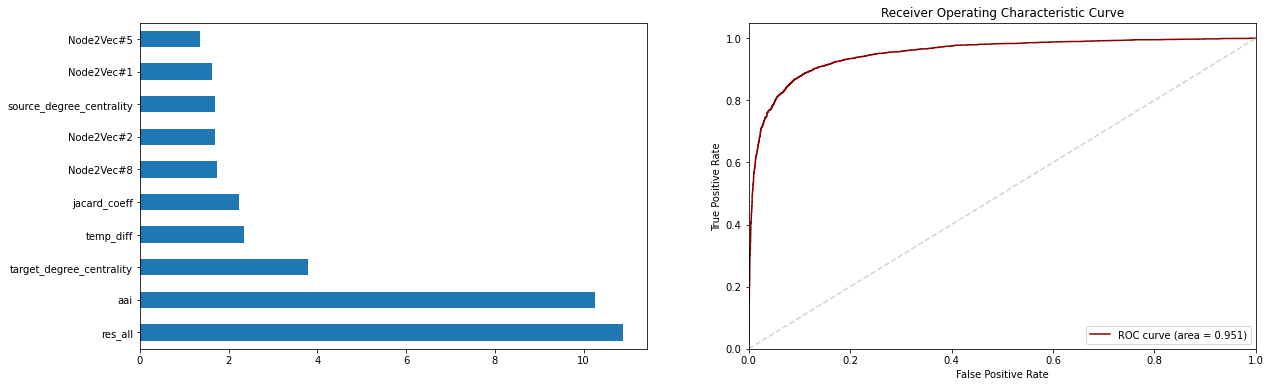

In [45]:
prediction(train_feat, val_feat, train_labels, val_labels)

In [46]:
def prediction_2(train_samples, test_samples, train_labels, test_labels):
# --- Build the model and train it ---
    # Fill in the blanks
    clf = xgb.XGBClassifier()
    clf.fit(train_samples, train_labels)

    train_preds = clf.predict_proba(train_samples)[:,1]
    test_preds = clf.predict_proba(test_samples)[:,1]
    
    labels_pred = clf.predict(test_samples)

    # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
    # Fill in the blanks
    fpr, tpr, _ = roc_curve(test_labels, test_preds)
    roc_auc = auc(fpr, tpr)
    
    print(f'Accuracy: {accuracy_score(test_labels, labels_pred)}')
    print(f'F1 score: {f1_score(test_labels, labels_pred)}')
    print(f'ROC: {roc_auc}')
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))

    pd.Series(abs(clf.feature_importances_), index=feat_name).nlargest(10).plot(kind='barh',ax=ax1)

    ax2.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    ax2.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver Operating Characteristic Curve')
    ax2.legend(loc="lower right")
    

    plt.show()

Accuracy: 0.9080408707241227
F1 score: 0.9051329055912009
ROC: 0.9652621935539384


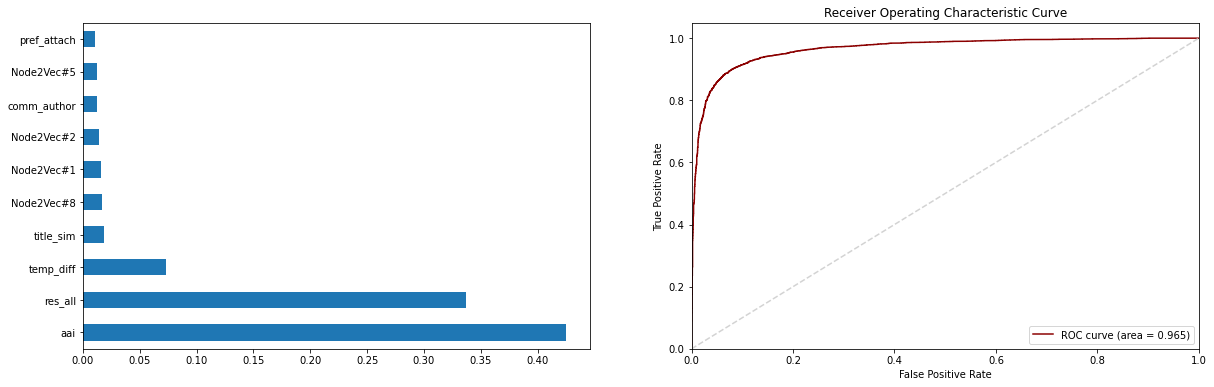

In [47]:
prediction_2(train_feat, val_feat, train_labels, val_labels)

## Test

In [48]:
with open("testing_set.txt", "r") as f:
    reader = csv.reader(f)
    testing_set  = list(reader)

testing_set = [element[0].split(" ") for element in testing_set]

In [ ]:
full_node2vec = Node2Vec(G, dimensions=embedding_size, walk_length=walk_length,
                    num_walks=num_of_walks, workers=4)
# Embed nodes
full_model = full_node2vec.fit(window=window_size, min_count=1, batch_words=4)

In [74]:
wv = KeyedVectors.load("full_graph_embedding.nodevectors", mmap='r')

In [65]:
test_graph_feat = feature_extractor_walk(G0, testing_set, model.wv, embedding_size)

Number of elements not found: 1911/65296


In [66]:
test_graph_undirected = feature_extractor_undirected(G_undirected, testing_set, deg_centrality)

30242


In [67]:
test_text_feat = processing_info(testing_set)

In [68]:
test_feat = np.concatenate([test_graph_feat,test_graph_undirected,test_text_feat],axis=1)

In [69]:
clf = xgb.XGBClassifier()
clf.fit(train_feat, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [70]:
predictions_SVM = list(clf.predict(test_feat))
predictions_SVM = list(zip(range(len(testing_set)), predictions_SVM))

prediction_svm = pd.DataFrame(predictions_SVM,columns=['id','category'])

In [71]:
prediction_svm.to_csv('pred.csv',index=False)